# **1. KMeans**


### **데이터 생성**
- 먼저, 군집화를 위한 toy 데이터를 생성하겠습니다.  
(주석을 달아두긴 했다만, 다변량 정규분포 개념이 들어가 이해하기 어려울 수도 있습니다.  
복잡한 데이터 생성을 위한 과정이라, 이해 안되시면 넘기셔도 됩니다.)


아래 코드를 실행시켜 주세요.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import multivariate_normal # 다변량 정규 분포

np.random.seed(4242) # random seed

In [2]:
### 시각화 설정

# colormap
colors = sns.color_palette("husl",8)
col = [colors[0],colors[1],colors[3],colors[5],colors[7]]
cols = ['b','g','r']

In [3]:
### 데이터 생성을 위한 설정
# 3개의 다변량 정규분포를 가정 후 데이터 생성

pi_true = np.array([0.2,0.5,0.3]) # 각 cluster에 속하는 데이터의 비율(2:5:3)
mu_true = np.array([[2,2],[-1,-1],[0,-1.4]]) # 각 cluster의 평균(center)

# 각 cluster의 var-covariance matrix
# 분산 정도로 생각하시면 됩니다.
sigma_true = np.zeros((3,2,2))
sigma_true[0] = np.array([[1.,0.3],[0.2,0.2]])
sigma_true[1] = np.array([[0.5,0.8],[0.8,0.5]])
sigma_true[2] = np.array([[1.3,0.3],[0.2,0.4]])

In [4]:
### Toy Dataset 생성

N = 100 # 데이터 개수
data = np.zeros((N,3)) # 데이터 저장을 위한 배열을 초기화

## 데이터 생성
for i in range(N):
    z = np.random.random() # 0 ~ 1의 난수 생성
    idx = 0 # cluster
    interval = 0 # 구간

    for j in range(len(pi_true)):
        # 현재 생성한 난수 값이 속하는 cluster를 인덱스로 지정
        if z >= interval and z <= interval+pi_true[j]:
            idx = j
            break
        else:
            interval += pi_true[j] # 다음 클러스터의 구간으로 이동

    # 다변량 정규 분포로부터 데이터 샘플링
    x, y = np.random.multivariate_normal(mu_true[idx],sigma_true[idx])
    data[i] = (x,y,idx) # 데이터 배열에 추가

<ipython-input-4-678acb625b84>:21: RuntimeWarning: covariance is not positive-semidefinite.
  x, y = np.random.multivariate_normal(mu_true[idx],sigma_true[idx])


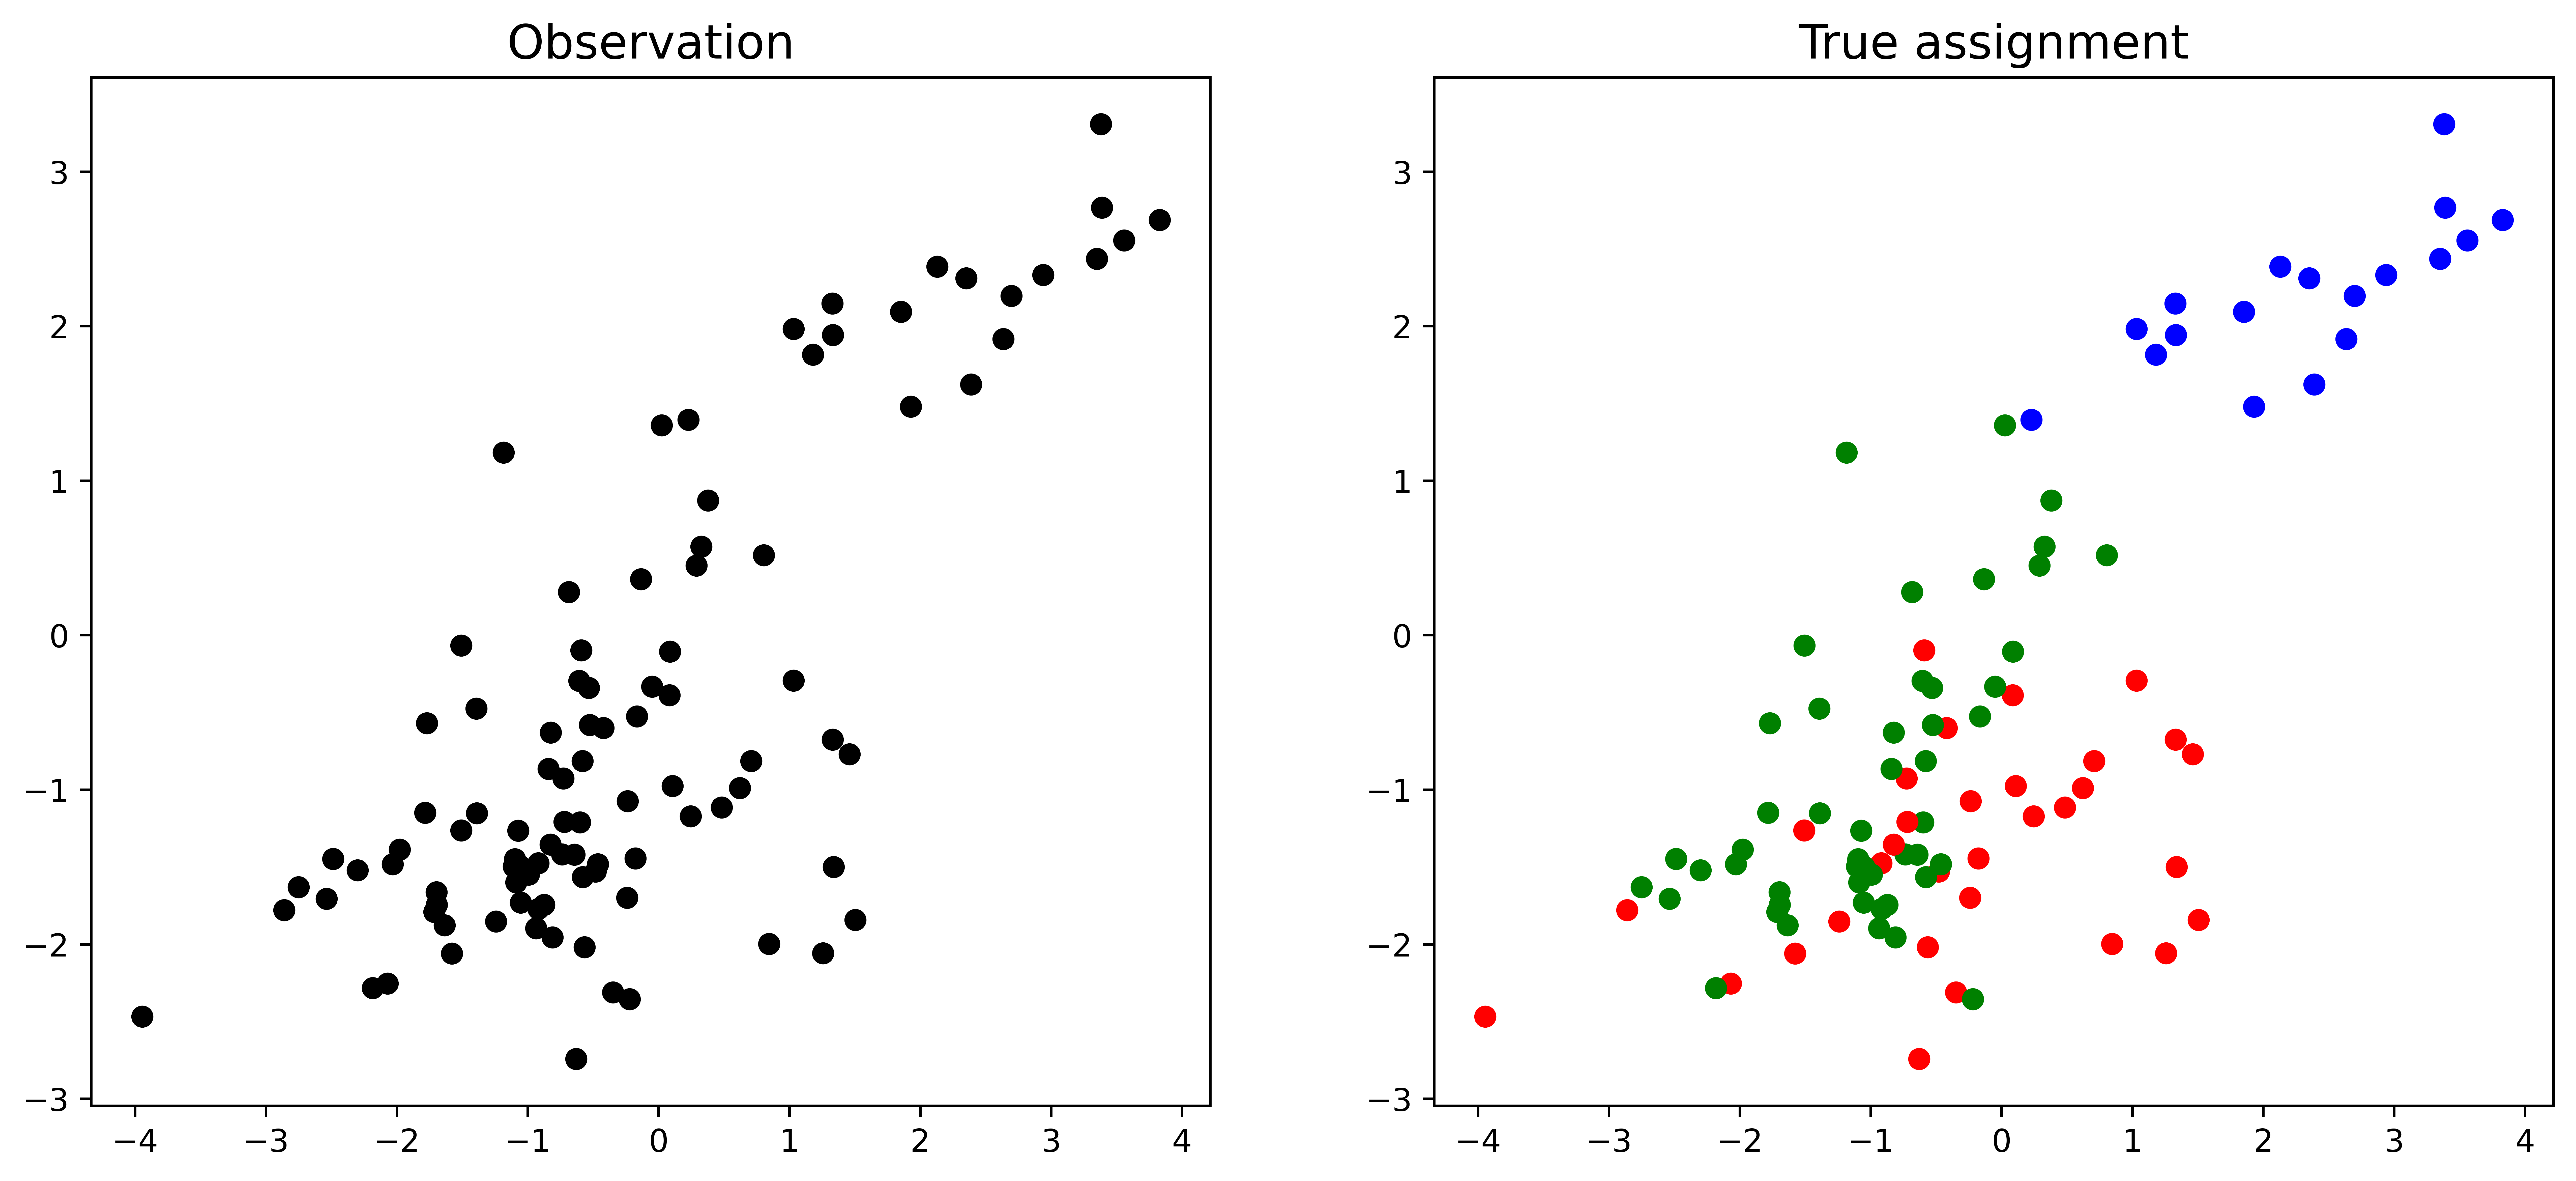

In [5]:
### 생성된 데이터 시각화

plt.figure(1,figsize = (14,6), dpi = 900)

## Observation(학습에 사용될 data point)
# 분포 모름, 어디서 왔는지도 모름
# 즉, clustering 시에는 라벨 정보가 없음
plt.subplot(121)
plt.title('Observation',fontsize = 15)
plt.plot(data[:,0],data[:,1],'ko')

## True Assignment(정답)
# label 정보가 포함됨
# 위에서 다변량 정규분포를 가정하였기에, 각 point가 속하는 cluster 정보를 파악할 수 있음
plt.subplot(122)
plt.title('True assignment',fontsize = 15)
for i in range(N):
    plt.plot(data[i,0],data[i,1],'o',c=cols[int(data[i,2])])

plt.show()

- 학습 시에는 cluster에 대한 정보가 없습니다.
  - 즉, 데이터 point에 대한 구분 없이 모든 점이 까만색으로 취급되는 것입니다.
- 이후 군집화를 통해 data point를 3개의 cluster(파란색, 초록색, 빨간색)로 나누고자 하는 것입니다.

In [6]:
### 데이터 분리
X = data[:, :2]
y = data[:, 2]

### 데이터프레임으로 가공
toyDF = pd.DataFrame(data = X, columns = ['ftr1', 'ftr2'])
toyDF['target'] = y
toyDF.head()

,ftr1,ftr2,target
0,-2.032063,-1.481299,1.0
1,0.803146,0.517739,1.0
2,-2.861891,-1.779394,2.0
3,3.348950,2.436819,0.0
4,1.851749,2.093774,0.0


## **1-1. 다음 조건을 만족하는 KMeans 객체를 만들어 주세요.**
- 군집화 개수: 3
- 초기에 군집 중심점의 좌표를 설정할 방식: `k-menas++`
- 최대 반복 횟수: 50

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=50)
cluster_labels = kmeans.fit_predict(X)
toyDF['cluster'] = cluster_labels
print(toyDF.groupby('target')['cluster'].value_counts())

target  cluster
0.0     1          17
        0           1
1.0     2          34
        0          16
2.0     0          17
        2          15
Name: cluster, dtype: int64


## **1-2. 아래 문제의 코드를 완성해 주세요.**
- 먼저, 주어진 데이터의 각 데이터 포인트의 실루엣 계수 값을 구하는 코드를 작성하세요.
- 이후, 모든 데이터의 평균 실루엣 계수 값을 구하는 코드를 작성하세요.

아래 코드의 빈칸을 채워 주세요.

In [8]:
# 실루엣 분석 metric 값을 구하기 위한 API 추가
from sklearn.metrics import silhouette_samples, silhouette_score

# 각 데이터 포인트의 실루엣 계수값을 구함.
score_samples = silhouette_samples(X, cluster_labels)
print('silhouette_samples( ) return 값의 shape' , score_samples.shape)

# clusterDF에 실루엣 계수 컬럼 추가
toyDF['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수값을 구함.
average_score = silhouette_score(X, cluster_labels)
print('Silhouette Analysis Score:{0:.3f}'.format(average_score))

silhouette_samples( ) return 값의 shape (100,)
Silhouette Analysis Score:0.446


# **2. 평균 이동(Mean Shift)**

## **2-1. 다음 조건을 만족하도록 빈칸을 채워주세요.**
- 데이터 생성
  - `make_blobs()`를 사용합니다.
  - 데이터 생성 시 파라미터 설정
    - `n_samples` = 200
    - `n_features` = 2
    - `centers` = 3
    - `cluster_std` = 0.7
    - `random_state` = 0

- MeanShift 클래스의 가장 중요한 초기화 파라미터로, KDE의 대역폭 h와 동일한 이 파라미터는 1로 설정합니다.

In [9]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

# 데이터 생성
X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

# 군집화
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:', np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


## **2-2. 최적 bandwidth 값을 찾아주세요.**

In [10]:
from sklearn.cluster import estimate_bandwidth

best_bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(best_bandwidth,3))

bandwidth 값: 1.816


- 최적화 된 bandwidth 값 적용

In [11]:
clusterDF = pd.DataFrame(data = X, columns = ['ftr1', 'ftr2'])
clusterDF['target'] = y

meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('cluster labels 유형:',np.unique(cluster_labels))

cluster labels 유형: [0 1 2]


## **2-3. 위에서 군집화 된 결과를 시각화 해보겠습니다.**
- 다음 빈칸을 채워주세요.

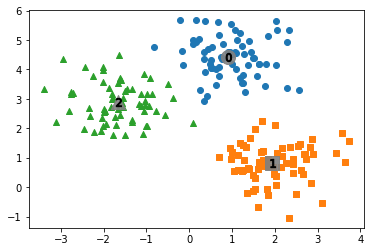

In [12]:
clusterDF['meanshift_label']  = cluster_labels
centers = meanshift.cluster_centers_
unique_labels = np.unique(cluster_labels)
markers = ['o', 's', '^', 'x', '*']

for label in unique_labels:
    label_cluster = clusterDF[clusterDF['meanshift_label'] == label]
    center_x_y = centers[label]

    # 군집별로 다른 마커로 산점도 적용
    plt.scatter(label_cluster['ftr1'], label_cluster['ftr2'], marker=markers[label])

    # 군집별 중심 표현
    plt.scatter(x = center_x_y[0], y = center_x_y[1], s = 200,
                color = 'gray', alpha = 0.9, marker = markers[label])
    plt.scatter(x = center_x_y[0], y = center_x_y[1], s = 70,
                color = 'k', edgecolor = 'k', marker = '$%d$' % label)

plt.show()

## **2-4. target 값과 군집 label 값을 비교해 봅시다.**
- 다음 빈칸을 채워주세요.

In [13]:
print(clusterDF.groupby(['target', 'meanshift_label']).size())

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
dtype: int64


# **3. GMM(Gaussian Mixture Model)**

## **3-1. 개념문제**
- 마크다운을 풀고 답안을 작성해 주세요!
- O/X 문제에서 틀린 답안의 경우 알맞게 고쳐주세요.

### **3-1-1.**  
GuassianMixture 객체의 가장 중요한 초기화 파라미터로, gaussian mixture의 모델의 총 개수를 의미하는 것은?

답: n_components 이다. 군집의 개수를 정하는 데 중요한 역할을 수행한다.

### **3-1-2.**
K-평균과 GMM 중 타원형으로 흩어져 있는 경우 더 효과적으로 군집화가 수행되는 방식은?

답: GMM 이다. K- 평균은 평균 거리 중심으로 중심을 이동하면서 군집화를 수행하는 방식이므로 개별 군집 내의 데이터가 원형으로 흩어져 있는 경우에 매우 효과적으로 군집화가 될 수 있다. 타원형으로 늘어선 경우엔 군집화를 잘 수행하지 못한다.

### **3-1-3.**
GMM과 달리 K-평균은 군집의 중심 좌표를 구할 수 없기 때문에 `visualize_cluster_plot()`에서 시각화되지 않는다.  (O/X)

답: X.  K-평균은 군집의 중심 좌표를 구할 수 있어서 visualize_cluster_plot()에서 시각화가 가능하다. 오히려 GMM이 K-평균과는 다르게 군집의 중심 좌표를 구할 수 없어 군집 중심 표현이 visualize_cluster_plot()에서 시각화되지 않는다.

### **3-1-4.**
GMM은 K-평균보다 유연하게 다양한 데이터 세트에 잘 적용될 수 있다는 장점이 있다. 하지만 군집화를 위한 수행 시간이 오래 걸린다는 단점이 있다.(O/X)

답: O

## **3-2. 실습문제**
- 1번에서 정의한 `toyDF`를 다시 활용하겠습니다.

In [14]:
toyDF.head(3) # 현재는 kmeans 군집화 결과가 저장되어 있음

,ftr1,ftr2,target,cluster,silhouette_coeff
0,-2.032063,-1.481299,1.0,2,0.591652
1,0.803146,0.517739,1.0,0,0.370479
2,-2.861891,-1.779394,2.0,2,0.505873


In [15]:
X = data[:, :2] # features
y = data[:, 2] # target

### **3-2-1. `n_components = 3`으로 설정하고 GMM 군집화를 수행해 주세요.**
- 아래 빈칸을 채워 주세요.

In [16]:
from sklearn.mixture import GaussianMixture

# GMM 군집화 수행
gmm = GaussianMixture(n_components=3, random_state=0).fit(X)
gmm_cluster_labels = gmm.predict(X)

# 군집화 결과를 toyDF의 'gmm_cluster' 칼럼 명으로 저장
toyDF['gmm_cluster'] = gmm_cluster_labels

# target 값에 따라 gmm_cluster 값이 어떻게 매핑됐는지 확인
toy_result = toyDF.groupby('target')['gmm_cluster'].value_counts()
print(toy_result)

target  gmm_cluster
0.0     1              18
1.0     0              35
        2              14
        1               1
2.0     0              19
        2              13
Name: gmm_cluster, dtype: int64


### **3-2-2. KMeans 군집화 결과와 비교를 진행해 보겠습니다.**
- 아래 빈칸을 채워주세요.

In [17]:
toy_kmeans = toyDF.groupby('target')['cluster'].value_counts()
print(toy_kmeans)

target  cluster
0.0     1          17
        0           1
1.0     2          34
        0          16
2.0     0          17
        2          15
Name: cluster, dtype: int64


- GMM과 KMeans의 군집화 결과를 비교 설명해 주세요.  
(아래 markdown을 풀고 작성해 주세요.)

답:  
KMeans : target 값과 어긋나는 경우가 많이 발생하고 있다.
GMM : 상대적으로 군집이 target 값과 잘 매핑되어 있다.

# **4. DBSCAN**

아래 코드를 실행해 주세요.

In [18]:
from sklearn.datasets import load_wine

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

wine = load_wine()

# 보다 편리한 데이터 Handling을 위해 DataFrame으로 변환
wineDF = pd.DataFrame(data=wine.data, columns=wine.feature_names)

## **4-1. 다음 코드를 완성해 주세요.**
- 빈칸을 채워주세요.

In [19]:
### 시각화를 위한 함수

def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_

    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)

        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)

        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'

    plt.legend(loc=legend_loc)
    plt.show()

In [20]:
from sklearn.cluster import DBSCAN

# 입실론을 0.6, 최소 데이터 개수를 7로 설정한 후 DBSCAN 함수를 완성하세요.
dbscan = DBSCAN(eps = 0.6, min_samples = 7, metric = 'euclidean')
dbscan_labels = dbscan.fit_predict(wine.data)

wineDF['dbscan_cluster'] = dbscan_labels
wineDF['target'] = wine.target

wine_result = wineDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(wine_result)

target  dbscan_cluster
0       -1                59
1       -1                71
2       -1                48
Name: dbscan_cluster, dtype: int64


**결과 시각화**  
- 아래 코드를 실행해 주세요.

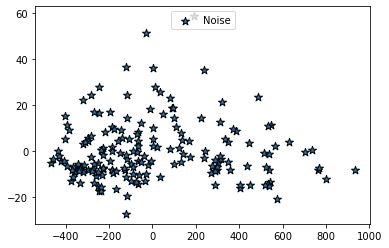

In [21]:
from sklearn.decomposition import PCA

# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=0)
pca_transformed = pca.fit_transform(wine.data)

# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
wineDF['ftr1'] = pca_transformed[:,0]
wineDF['ftr2'] = pca_transformed[:,1]

visualize_cluster_plot(dbscan, wineDF, 'dbscan_cluster', iscenter=False)

## **4-2. DBSCAN의 파라미터를 변경하여 군집화를 수행해 보겠습니다.**
- 아래 코드의 빈칸을 채워주세요.

target  dbscan_cluster
0       -1                59
1       -1                71
2       -1                48
Name: dbscan_cluster, dtype: int64


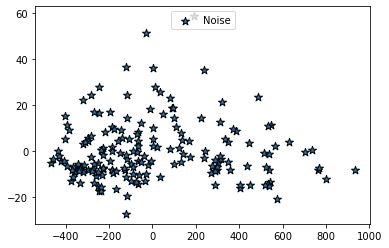

In [22]:
from sklearn.cluster import DBSCAN

# 입실론을 0.8, 최소 데이터 개수를 7로 설정한 후 DBSCAN 함수를 완성하세요.
dbscan = DBSCAN(eps = 0.8, min_samples = 7, metric='euclidean')
dbscan_labels = dbscan.fit_predict(wine.data)

wineDF['dbscan_cluster'] = dbscan_labels
wineDF['target'] = wine.target

wine_result = wineDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(wine_result)

visualize_cluster_plot(dbscan, wineDF, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0       -1                59
1       -1                71
2       -1                48
Name: dbscan_cluster, dtype: int64


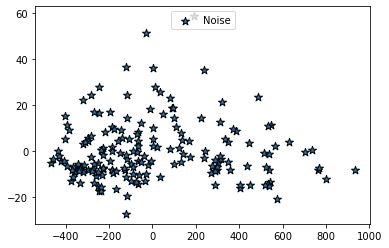

In [23]:
# 입실론을 0.7, 최소 데이터 개수를 16으로 설정한 후 DBSCAN 함수를 완성하세요.
dbscan = DBSCAN(eps = 0.7, min_samples = 16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(wine.data)

wineDF['dbscan_cluster'] = dbscan_labels
wineDF['target'] = wine.target

wine_result = wineDF.groupby(['target'])['dbscan_cluster'].value_counts()
print(wine_result)

visualize_cluster_plot(dbscan, wineDF, 'dbscan_cluster', iscenter=False)

## **4-3.DBSCAN은 다른 클러스터와 달리 밀도 기반 군집화 방법이라고 한다. 이러한 밀도 기반의 클러스터링이 어떤 방식을 의미하는지 쓰시오.**

답: 입실론 주변 영역의 최소 데이터 개수를 포함하는 밀도 기준을 충족시키는 데이터인 핵심 포인트를 연결하면서 군집화를 구성하는 방식을 말한다.

# **5. 군집화 실습 - 고객 세그먼테이션**

## **5-1. RFM 기법에서 각 요소의 의미를 서술하세요.**


답:
- **R** : 가장 최근 상품 구입 일에서 오늘까지의 기간
- **F** : 상품 구매 횟수
- **M** : 총 구매 금액

## **5-2. RFM 기법을 활용하여 고객 세그먼테이션을 수행해보겠습니다. 아래 안내에 따라 수행하며, 빈칸을 채워주세요.**

⬇️ 데이터셋은 여기서 다운로드합니다.⬇️

https://archive.ics.uci.edu/dataset/352/online+retail

📌 파일 경로와 관련된 코드의 경우 각자에게 맞게 설정해주시면 됩니다.

In [24]:
# 아래 코드를 실행해주세요.

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel('./Online Retail.xlsx')

In [25]:
# 아래 코드를 실행해주세요.

retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
retail_df = retail_df[retail_df['Country']=='United Kingdom']

In [26]:
# 빈칸을 완성해주세요.

retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}

# 고객별로 집계하기
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
cust_df = cust_df.rename(columns = {'InvoiceDate': 'Recency',  
                                    'InvoiceNo': 'Frequency',
                                    'sale_amount': 'Monetary' 
                                    }
                        )
cust_df = cust_df.reset_index()

import datetime as dt
cust_df['Recency'] = dt.datetime.now() - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_of 로우와 칼럼 건수는 ', cust_df.shape)
cust_df.head(3)

cust_of 로우와 칼럼 건수는  (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,4880,1,77183.60
1,12747,4557,103,4196.01
2,12748,4555,4595,33719.73
